# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


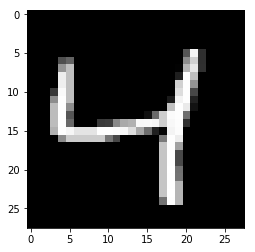

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [18]:
learning_rate = 0.001

image_size = mnist.train.images.shape[1]
# Input and target placeholders
inputs_ = tf.placeholder(tf.float32,[None,28,28,1])
targets_ = tf.placeholder(tf.float32,[None,28,28,1])

### Encoder
#increase depth from 1 to 16 (units=16)
conv1 = tf.layers.conv2d(inputs_,16,2,padding='same',activation=tf.nn.relu)
# Now 28x28x16
# decrease hxw by 2 (pool size =2)
maxpool1 = tf.layers.max_pooling2d(conv1,2,1)
# Now 14x14x16
# decrease depth from 16 to 8 (units=8)
conv2 = tf.layers.conv2d(maxpool1,8,2,padding='same',activation=tf.nn.relu)
# Now 14x14x8
# decrease hxw by 2 (pool_size=2)
maxpool2 = tf.layers.max_pooling2d(conv2,2,1)
# Now 7x7x8
# keep depth at 8
conv3 = tf.layers.conv2d(maxpool2,8,2,padding='same',activation=tf.nn.relu)
# Now 7x7x8
# decrease hxw from 7 to 4
encoded = tf.layers.max_pooling2d(conv3,2,1)
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded,[7,7])
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1,8,2,padding='same',activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(conv4,[14,14])
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2,8,2,padding='same',activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv5,[28,28])
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3,16,2,padding='same',activation=tf.nn.relu)
# Now 28x28x16

# output depth is reduced to 1
logits = tf.layers.dense(conv6, units=1,activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=targets_)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [21]:
sess = tf.Session()

In [22]:
epochs = 8
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/8... Training loss: 0.6882
Epoch: 1/8... Training loss: 0.6847
Epoch: 1/8... Training loss: 0.6805
Epoch: 1/8... Training loss: 0.6762
Epoch: 1/8... Training loss: 0.6710
Epoch: 1/8... Training loss: 0.6658
Epoch: 1/8... Training loss: 0.6602
Epoch: 1/8... Training loss: 0.6534
Epoch: 1/8... Training loss: 0.6468
Epoch: 1/8... Training loss: 0.6390
Epoch: 1/8... Training loss: 0.6301
Epoch: 1/8... Training loss: 0.6234
Epoch: 1/8... Training loss: 0.6139
Epoch: 1/8... Training loss: 0.6054
Epoch: 1/8... Training loss: 0.5966
Epoch: 1/8... Training loss: 0.5875
Epoch: 1/8... Training loss: 0.5796
Epoch: 1/8... Training loss: 0.5722
Epoch: 1/8... Training loss: 0.5615
Epoch: 1/8... Training loss: 0.5541
Epoch: 1/8... Training loss: 0.5497
Epoch: 1/8... Training loss: 0.5420
Epoch: 1/8... Training loss: 0.5363
Epoch: 1/8... Training loss: 0.5310
Epoch: 1/8... Training loss: 0.5263
Epoch: 1/8... Training loss: 0.5213
Epoch: 1/8... Training loss: 0.5253
Epoch: 1/8... Training loss:

Epoch: 1/8... Training loss: 0.1596
Epoch: 1/8... Training loss: 0.1580
Epoch: 1/8... Training loss: 0.1571
Epoch: 1/8... Training loss: 0.1580
Epoch: 1/8... Training loss: 0.1564
Epoch: 1/8... Training loss: 0.1503
Epoch: 1/8... Training loss: 0.1554
Epoch: 1/8... Training loss: 0.1560
Epoch: 1/8... Training loss: 0.1578
Epoch: 1/8... Training loss: 0.1513
Epoch: 1/8... Training loss: 0.1516
Epoch: 1/8... Training loss: 0.1564
Epoch: 1/8... Training loss: 0.1528
Epoch: 1/8... Training loss: 0.1550
Epoch: 1/8... Training loss: 0.1530
Epoch: 1/8... Training loss: 0.1526
Epoch: 1/8... Training loss: 0.1545
Epoch: 1/8... Training loss: 0.1510
Epoch: 1/8... Training loss: 0.1547
Epoch: 1/8... Training loss: 0.1542
Epoch: 1/8... Training loss: 0.1536
Epoch: 1/8... Training loss: 0.1514
Epoch: 1/8... Training loss: 0.1546
Epoch: 1/8... Training loss: 0.1522
Epoch: 1/8... Training loss: 0.1470
Epoch: 1/8... Training loss: 0.1451
Epoch: 1/8... Training loss: 0.1485
Epoch: 1/8... Training loss:

Epoch: 2/8... Training loss: 0.1367
Epoch: 2/8... Training loss: 0.1328
Epoch: 2/8... Training loss: 0.1385
Epoch: 2/8... Training loss: 0.1359
Epoch: 2/8... Training loss: 0.1357
Epoch: 2/8... Training loss: 0.1359
Epoch: 2/8... Training loss: 0.1323
Epoch: 2/8... Training loss: 0.1370
Epoch: 2/8... Training loss: 0.1335
Epoch: 2/8... Training loss: 0.1383
Epoch: 2/8... Training loss: 0.1287
Epoch: 2/8... Training loss: 0.1371
Epoch: 2/8... Training loss: 0.1376
Epoch: 2/8... Training loss: 0.1338
Epoch: 2/8... Training loss: 0.1376
Epoch: 2/8... Training loss: 0.1354
Epoch: 2/8... Training loss: 0.1313
Epoch: 2/8... Training loss: 0.1335
Epoch: 2/8... Training loss: 0.1386
Epoch: 2/8... Training loss: 0.1352
Epoch: 2/8... Training loss: 0.1306
Epoch: 2/8... Training loss: 0.1341
Epoch: 2/8... Training loss: 0.1337
Epoch: 2/8... Training loss: 0.1327
Epoch: 2/8... Training loss: 0.1361
Epoch: 2/8... Training loss: 0.1387
Epoch: 2/8... Training loss: 0.1310
Epoch: 2/8... Training loss:

Epoch: 3/8... Training loss: 0.1297
Epoch: 3/8... Training loss: 0.1297
Epoch: 3/8... Training loss: 0.1287
Epoch: 3/8... Training loss: 0.1281
Epoch: 3/8... Training loss: 0.1306
Epoch: 3/8... Training loss: 0.1261
Epoch: 3/8... Training loss: 0.1265
Epoch: 3/8... Training loss: 0.1206
Epoch: 3/8... Training loss: 0.1267
Epoch: 3/8... Training loss: 0.1257
Epoch: 3/8... Training loss: 0.1289
Epoch: 3/8... Training loss: 0.1337
Epoch: 3/8... Training loss: 0.1306
Epoch: 3/8... Training loss: 0.1302
Epoch: 3/8... Training loss: 0.1304
Epoch: 3/8... Training loss: 0.1288
Epoch: 3/8... Training loss: 0.1262
Epoch: 3/8... Training loss: 0.1276
Epoch: 3/8... Training loss: 0.1240
Epoch: 3/8... Training loss: 0.1254
Epoch: 3/8... Training loss: 0.1270
Epoch: 3/8... Training loss: 0.1223
Epoch: 3/8... Training loss: 0.1283
Epoch: 3/8... Training loss: 0.1295
Epoch: 3/8... Training loss: 0.1277
Epoch: 3/8... Training loss: 0.1256
Epoch: 3/8... Training loss: 0.1244
Epoch: 3/8... Training loss:

Epoch: 4/8... Training loss: 0.1200
Epoch: 4/8... Training loss: 0.1241
Epoch: 4/8... Training loss: 0.1185
Epoch: 4/8... Training loss: 0.1190
Epoch: 4/8... Training loss: 0.1221
Epoch: 4/8... Training loss: 0.1214
Epoch: 4/8... Training loss: 0.1232
Epoch: 4/8... Training loss: 0.1191
Epoch: 4/8... Training loss: 0.1204
Epoch: 4/8... Training loss: 0.1188
Epoch: 4/8... Training loss: 0.1210
Epoch: 4/8... Training loss: 0.1193
Epoch: 4/8... Training loss: 0.1225
Epoch: 4/8... Training loss: 0.1240
Epoch: 4/8... Training loss: 0.1229
Epoch: 4/8... Training loss: 0.1224
Epoch: 4/8... Training loss: 0.1211
Epoch: 4/8... Training loss: 0.1209
Epoch: 4/8... Training loss: 0.1192
Epoch: 4/8... Training loss: 0.1240
Epoch: 4/8... Training loss: 0.1214
Epoch: 4/8... Training loss: 0.1228
Epoch: 4/8... Training loss: 0.1218
Epoch: 4/8... Training loss: 0.1180
Epoch: 4/8... Training loss: 0.1223
Epoch: 4/8... Training loss: 0.1218
Epoch: 4/8... Training loss: 0.1203
Epoch: 4/8... Training loss:

Epoch: 4/8... Training loss: 0.1173
Epoch: 4/8... Training loss: 0.1212
Epoch: 4/8... Training loss: 0.1216
Epoch: 4/8... Training loss: 0.1162
Epoch: 4/8... Training loss: 0.1211
Epoch: 4/8... Training loss: 0.1205
Epoch: 4/8... Training loss: 0.1179
Epoch: 4/8... Training loss: 0.1163
Epoch: 4/8... Training loss: 0.1218
Epoch: 4/8... Training loss: 0.1162
Epoch: 4/8... Training loss: 0.1170
Epoch: 4/8... Training loss: 0.1199
Epoch: 4/8... Training loss: 0.1164
Epoch: 4/8... Training loss: 0.1179
Epoch: 4/8... Training loss: 0.1151
Epoch: 4/8... Training loss: 0.1191
Epoch: 4/8... Training loss: 0.1188
Epoch: 4/8... Training loss: 0.1177
Epoch: 4/8... Training loss: 0.1181
Epoch: 4/8... Training loss: 0.1158
Epoch: 4/8... Training loss: 0.1114
Epoch: 4/8... Training loss: 0.1181
Epoch: 4/8... Training loss: 0.1152
Epoch: 4/8... Training loss: 0.1171
Epoch: 4/8... Training loss: 0.1185
Epoch: 4/8... Training loss: 0.1150
Epoch: 4/8... Training loss: 0.1213
Epoch: 4/8... Training loss:

Epoch: 5/8... Training loss: 0.1151
Epoch: 5/8... Training loss: 0.1179
Epoch: 5/8... Training loss: 0.1171
Epoch: 5/8... Training loss: 0.1134
Epoch: 5/8... Training loss: 0.1167
Epoch: 5/8... Training loss: 0.1137
Epoch: 5/8... Training loss: 0.1181
Epoch: 5/8... Training loss: 0.1135
Epoch: 5/8... Training loss: 0.1148
Epoch: 5/8... Training loss: 0.1158
Epoch: 5/8... Training loss: 0.1163
Epoch: 5/8... Training loss: 0.1140
Epoch: 5/8... Training loss: 0.1190
Epoch: 5/8... Training loss: 0.1183
Epoch: 5/8... Training loss: 0.1181
Epoch: 5/8... Training loss: 0.1163
Epoch: 5/8... Training loss: 0.1134
Epoch: 5/8... Training loss: 0.1134
Epoch: 5/8... Training loss: 0.1182
Epoch: 5/8... Training loss: 0.1127
Epoch: 5/8... Training loss: 0.1138
Epoch: 5/8... Training loss: 0.1163
Epoch: 5/8... Training loss: 0.1156
Epoch: 5/8... Training loss: 0.1210
Epoch: 5/8... Training loss: 0.1156
Epoch: 5/8... Training loss: 0.1166
Epoch: 5/8... Training loss: 0.1179
Epoch: 5/8... Training loss:

Epoch: 6/8... Training loss: 0.1119
Epoch: 6/8... Training loss: 0.1123
Epoch: 6/8... Training loss: 0.1125
Epoch: 6/8... Training loss: 0.1090
Epoch: 6/8... Training loss: 0.1124
Epoch: 6/8... Training loss: 0.1127
Epoch: 6/8... Training loss: 0.1134
Epoch: 6/8... Training loss: 0.1127
Epoch: 6/8... Training loss: 0.1155
Epoch: 6/8... Training loss: 0.1176
Epoch: 6/8... Training loss: 0.1157
Epoch: 6/8... Training loss: 0.1130
Epoch: 6/8... Training loss: 0.1087
Epoch: 6/8... Training loss: 0.1141
Epoch: 6/8... Training loss: 0.1153
Epoch: 6/8... Training loss: 0.1089
Epoch: 6/8... Training loss: 0.1101
Epoch: 6/8... Training loss: 0.1097
Epoch: 6/8... Training loss: 0.1203
Epoch: 6/8... Training loss: 0.1153
Epoch: 6/8... Training loss: 0.1114
Epoch: 6/8... Training loss: 0.1134
Epoch: 6/8... Training loss: 0.1133
Epoch: 6/8... Training loss: 0.1145
Epoch: 6/8... Training loss: 0.1192
Epoch: 6/8... Training loss: 0.1106
Epoch: 6/8... Training loss: 0.1167
Epoch: 6/8... Training loss:

Epoch: 7/8... Training loss: 0.1144
Epoch: 7/8... Training loss: 0.1091
Epoch: 7/8... Training loss: 0.1140
Epoch: 7/8... Training loss: 0.1134
Epoch: 7/8... Training loss: 0.1078
Epoch: 7/8... Training loss: 0.1129
Epoch: 7/8... Training loss: 0.1127
Epoch: 7/8... Training loss: 0.1113
Epoch: 7/8... Training loss: 0.1105
Epoch: 7/8... Training loss: 0.1112
Epoch: 7/8... Training loss: 0.1117
Epoch: 7/8... Training loss: 0.1136
Epoch: 7/8... Training loss: 0.1140
Epoch: 7/8... Training loss: 0.1113
Epoch: 7/8... Training loss: 0.1121
Epoch: 7/8... Training loss: 0.1086
Epoch: 7/8... Training loss: 0.1091
Epoch: 7/8... Training loss: 0.1107
Epoch: 7/8... Training loss: 0.1081
Epoch: 7/8... Training loss: 0.1160
Epoch: 7/8... Training loss: 0.1109
Epoch: 7/8... Training loss: 0.1109
Epoch: 7/8... Training loss: 0.1133
Epoch: 7/8... Training loss: 0.1144
Epoch: 7/8... Training loss: 0.1164
Epoch: 7/8... Training loss: 0.1158
Epoch: 7/8... Training loss: 0.1109
Epoch: 7/8... Training loss:

Epoch: 7/8... Training loss: 0.1087
Epoch: 7/8... Training loss: 0.1089
Epoch: 7/8... Training loss: 0.1101
Epoch: 7/8... Training loss: 0.1098
Epoch: 7/8... Training loss: 0.1072
Epoch: 7/8... Training loss: 0.1141
Epoch: 7/8... Training loss: 0.1110
Epoch: 7/8... Training loss: 0.1116
Epoch: 7/8... Training loss: 0.1114
Epoch: 7/8... Training loss: 0.1130
Epoch: 7/8... Training loss: 0.1105
Epoch: 7/8... Training loss: 0.1085
Epoch: 7/8... Training loss: 0.1117
Epoch: 7/8... Training loss: 0.1112
Epoch: 7/8... Training loss: 0.1131
Epoch: 7/8... Training loss: 0.1125
Epoch: 7/8... Training loss: 0.1105
Epoch: 7/8... Training loss: 0.1093
Epoch: 7/8... Training loss: 0.1105
Epoch: 7/8... Training loss: 0.1111
Epoch: 7/8... Training loss: 0.1082
Epoch: 7/8... Training loss: 0.1090
Epoch: 7/8... Training loss: 0.1122
Epoch: 7/8... Training loss: 0.1160
Epoch: 7/8... Training loss: 0.1106
Epoch: 7/8... Training loss: 0.1076
Epoch: 7/8... Training loss: 0.1102
Epoch: 7/8... Training loss:

Epoch: 8/8... Training loss: 0.1085
Epoch: 8/8... Training loss: 0.1114
Epoch: 8/8... Training loss: 0.1061
Epoch: 8/8... Training loss: 0.1122
Epoch: 8/8... Training loss: 0.1087
Epoch: 8/8... Training loss: 0.1102
Epoch: 8/8... Training loss: 0.1108
Epoch: 8/8... Training loss: 0.1064
Epoch: 8/8... Training loss: 0.1095
Epoch: 8/8... Training loss: 0.1093
Epoch: 8/8... Training loss: 0.1072
Epoch: 8/8... Training loss: 0.1077
Epoch: 8/8... Training loss: 0.1085
Epoch: 8/8... Training loss: 0.1115
Epoch: 8/8... Training loss: 0.1097
Epoch: 8/8... Training loss: 0.1091
Epoch: 8/8... Training loss: 0.1099
Epoch: 8/8... Training loss: 0.1100
Epoch: 8/8... Training loss: 0.1140
Epoch: 8/8... Training loss: 0.1104
Epoch: 8/8... Training loss: 0.1102
Epoch: 8/8... Training loss: 0.1119
Epoch: 8/8... Training loss: 0.1086
Epoch: 8/8... Training loss: 0.1086
Epoch: 8/8... Training loss: 0.1116
Epoch: 8/8... Training loss: 0.1084
Epoch: 8/8... Training loss: 0.1092
Epoch: 8/8... Training loss:

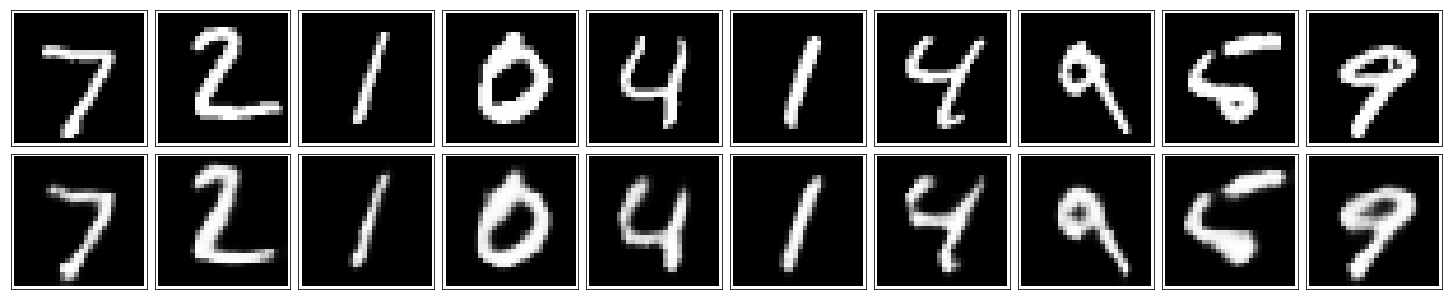

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [24]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [29]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_,32,2,padding='same',activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1,2,1)
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1,32,2,padding='same',activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2,2,1)
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2,16,2,padding='same',activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv2,2,1)
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded,[7,7])
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1,16,2,padding='same',activation=tf.nn.relu)
# Now 7x7x16
upsample2 =  tf.image.resize_nearest_neighbor(conv4,[14,14])
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2,32,2,padding='same',activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv4,[28,28])
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3,32,2,padding='same',activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.dense(conv6,1,activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss =  tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=targets_)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [32]:
sess = tf.Session()

In [33]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))
        if (batch_cost < 0.18):
            break
    if (batch_cost < 0.18):
        break

Epoch: 1/100... Training loss: 0.7083
Epoch: 1/100... Training loss: 0.6958
Epoch: 1/100... Training loss: 0.6853
Epoch: 1/100... Training loss: 0.6752
Epoch: 1/100... Training loss: 0.6648
Epoch: 1/100... Training loss: 0.6546
Epoch: 1/100... Training loss: 0.6424
Epoch: 1/100... Training loss: 0.6310
Epoch: 1/100... Training loss: 0.6176
Epoch: 1/100... Training loss: 0.6044
Epoch: 1/100... Training loss: 0.5917
Epoch: 1/100... Training loss: 0.5724
Epoch: 1/100... Training loss: 0.5619
Epoch: 1/100... Training loss: 0.5448
Epoch: 1/100... Training loss: 0.5278
Epoch: 1/100... Training loss: 0.5181
Epoch: 1/100... Training loss: 0.5003
Epoch: 1/100... Training loss: 0.4891
Epoch: 1/100... Training loss: 0.4815
Epoch: 1/100... Training loss: 0.4702
Epoch: 1/100... Training loss: 0.4689
Epoch: 1/100... Training loss: 0.4710
Epoch: 1/100... Training loss: 0.4703
Epoch: 1/100... Training loss: 0.4692
Epoch: 1/100... Training loss: 0.4897
Epoch: 1/100... Training loss: 0.4881
Epoch: 1/100

Epoch: 1/100... Training loss: 0.1837
Epoch: 1/100... Training loss: 0.1870
Epoch: 1/100... Training loss: 0.1807
Epoch: 1/100... Training loss: 0.1811
Epoch: 1/100... Training loss: 0.1869
Epoch: 1/100... Training loss: 0.1807
Epoch: 1/100... Training loss: 0.1841
Epoch: 1/100... Training loss: 0.1847
Epoch: 1/100... Training loss: 0.1820
Epoch: 1/100... Training loss: 0.1796


## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

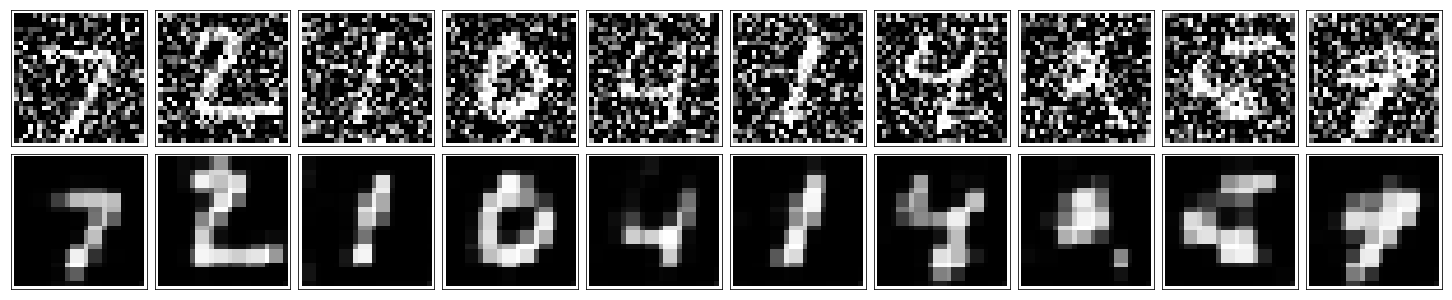

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)